# Start-to-Finish Example: Setting up Polytropic [TOV](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation) Initial Data, in Curvilinear Coordinates

## *TOV Solver courtesy Phil Chang*

## This module sets up initial data for a TOV star in *spherical, isotropic coordinates*, using the *Numerical* ADM Spherical to BSSN Curvilinear initial data module (numerical = BSSN $\lambda^i$'s are computed using finite-difference derivatives instead of exact expressions).

<font color='green'>**This module has been validated to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution (see plot at bottom). Note that convergence at the surface of the star will be lower order due to the sharp drop to zero in $T^{\mu\nu}$.**</font>

### NRPy+ Source Code for this module: 
1. [BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py](../edit/BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb): *Numerical* Spherical ADM$\to$Curvilinear BSSN converter function
1. [BSSN/BSSN_Constraints.py](../edit/BSSN/BSSNConstraints.py); [\[**tutorial**\]](Tutorial-BSSNConstraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates

Here we use NRPy+ to generate initial data for a [simple polytrope TOV star](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation).

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. <font color='green'>Set gridfunction values to initial data (**This module**).</font>
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. <font color='green'>Evaluate BSSN RHS expressions.</font>
    1. Apply singular, curvilinear coordinate boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)
    1. <font color='green'>Apply constraints on conformal 3-metric: $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$</font>
1. At the end of each iteration in time, output the <font color='green'>Hamiltonian constraint violation</font>.
1. Repeat above steps at two numerical resolutions to confirm convergence to zero.

## Set core NRPy+ parameters for numerical grids and reference metric

In [1]:
# First we import needed core NRPy+ modules
from outputC import *
import NRPy_param_funcs as par
import grid as gri
import loop as lp
import indexedexp as ixp
import finite_difference as fin
import reference_metric as rfm

thismodule = "TOV_ID_setup"

# Set spatial dimension (must be 3 for BSSN)
DIM = 3
par.set_parval_from_str("grid::DIM",DIM)

# Then we set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem","Spherical")
rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating BSSN RHSs, etc.

# We will need the h_{ij} quantities defined within BSSN_RHSs 
#    below when we enforce the gammahat=gammabar constraint
import BSSN.BSSN_RHSs as rhs
par.set_parval_from_str("BSSN.BSSN_RHSs::ConformalFactor","phi")
rhs.BSSN_RHSs()

#################
# Next output C headers related to the numerical grids we just set up:
#################

# First output the coordinate bounds xxmin[] and xxmax[]:
with open("BSSN/xxminmax.h", "w") as file:
    file.write("const REAL xxmin[3] = {"+str(rfm.xxmin[0])+","+str(rfm.xxmin[1])+","+str(rfm.xxmin[2])+"};\n")
    file.write("const REAL xxmax[3] = {"+str(rfm.xxmax[0])+","+str(rfm.xxmax[1])+","+str(rfm.xxmax[2])+"};\n")

# Generic coordinate NRPy+ file output, Part 2: output the conversion from (x0,x1,x2) to Cartesian (x,y,z)
outputC([rfm.xxCart[0],rfm.xxCart[1],rfm.xxCart[2]],["xCart[0]","xCart[1]","xCart[2]"],
        "BSSN/xxCart.h")

# Register the Hamiltonian as a gridfunction, to be used later.
H = gri.register_gridfunctions("AUX","H")

initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::RMAX
Wrote to file "BSSN/xxCart.h"


## Set up ADM initial data for polytropic TOV

As documented [here](Tutorial-GRMHD_UnitConversion.ipynb), we will now set up TOV initial data, storing the densely-sampled result to file (***Courtesy Phil Chang***):

We output

In [2]:
!pip install scipy > /dev/null

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Solving the TOV equations

The [TOV line element](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation) in terms of the *Schwarzschild coordinate* $r$ is written (in the $-+++$ form):
$$
ds^2 = - c^2 e^\nu dt^2 + \left(1 - \frac{2Gm}{rc^2}\right)^{-1} dr^2 + r^2 d\Omega^2,
$$
where $m(r)$ is the mass-energy enclosed at a given $r$, and is equal to the total star's mass outside the stellar radius $r=R$.

In terms of the *isotropic coordinate* $\bar{r}$ with $G=c=1$ (i.e., the coordinate system we'd prefer to use), the ($-+++$ form) line element is written:
$$
ds^2 = - e^{\nu} dt^2 + e^{4\phi} \left(d\bar{r}^2 + \bar{r}^2 d\Omega^2\right),
$$
where $\phi$ here is the *conformal factor*.

Setting components of the above line element equal to one another, we get (in $G=c=1$ units):

\begin{align}
r^2 &= e^{4\phi} \bar{r}^2 \implies e^{4\phi} = \frac{r^2}{\bar{r}^2} \\
\left(1 - \frac{2m}{r}\right)^{-1} dr^2 &= e^{4\phi} d\bar{r}^2 \\
\implies \frac{d\bar{r}(r)}{dr} &= \left(1 - \frac{2m}{r} \right)^{-1/2} \frac{\bar{r}(r)}{r}.
\end{align}

The TOV equations provide radial ODEs for the pressure and $\nu$ (from [the Wikipedia article on the TOV solution](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation)):

\begin{align}
\frac{dP}{dr} &= - \frac{1}{r} \left( \frac{\rho + P}{2} \right) \left(\frac{2 m}{r} + 8 \pi r^2 P\right) \left(1 - \frac{2 m}{r}\right)^{-1} \\
\frac{d \nu}{d r} &= \frac{1}{r}\left(1 - \frac{2 m}{r}\right)^{-1} \left(\frac{2 m}{r} + 8 \pi r^2 P\right) \\
\end{align}

Assuming a polytropic equation of state, which relates the pressure $P$ to the baryonic rest-mass density $\rho_B$,

$$
P(\rho_B) = K \rho_B^\Gamma,
$$
the specific internal energy will be given by
$$
\epsilon = \frac{P}{\rho_B (\Gamma - 1)},
$$

so the total mass-energy density $\rho$ is given by
$$
\rho = \rho_B (1 + \epsilon).
$$

Given this, the mass-energy $m(r)$ density is the solution to the ODE:
$$
\frac{m(r)}{dr} = 4\pi r^2 \rho(r)
$$

Thus the full set of ODEs that need to be solved is given by

\begin{align}
\frac{dP}{dr} &= - \frac{1}{r} \left( \frac{\rho + P}{2} \right) \left(\frac{2 m}{r} + 8 \pi r^2 P\right) \left(1 - \frac{2 m}{r}\right)^{-1} \\
\frac{d \nu}{d r} &= \frac{1}{r}\left(1 - \frac{2 m}{r}\right)^{-1} \left(\frac{2 m}{r} + 8 \pi r^2 P\right) \\
\frac{m(r)}{dr} &= 4\pi r^2 \rho(r) \\
\frac{d\bar{r}(r)}{dr} &= \left(1 - \frac{2m}{r} \right)^{-1/2} \frac{\bar{r}(r)}{r}.
\end{align}

The following code solves these equations, and is courtesy Phil Chang:

In [3]:
## TOV SOLVER FOR SIMPLE POLYTROPES, COURTESY PHIL CHANG.

# rbar refers to the isotropic radius, and
# R_Schw refers to the Schwarzschild radius

import numpy as np
import scipy.integrate as si
import math

n = 1.
rho_baryon_central = 0.129285

P0 = 1. # ZACH NOTES: CHANGED FROM 100.
gamma = 1. + 1./n
gam1 = gamma - 1.

def TOV_pressure( rho_baryon) : 
    return P0*rho_baryon**gamma

def TOV_rhs(r_Schw, y) : 
# In \tilde units
#
    P    = y[0]
    m    = y[1]
    nu   = y[2]
    rbar = y[3]
    
    dPdrSchw    = 0.
    drbardrSchw = 0.
    
    rho_baryon = (P/P0)**(1./gamma)
    rho = rho_baryon + P/gam1 # rho is the *total* mass-energy density!
    if( r_Schw < 1e-4 or m <= 0.): 
        m = 4*math.pi/3. * rho*r_Schw**3
        dPdrSchw = -(rho + P)*(4.*math.pi/3.*r_Schw*rho + 4.*math.pi*r_Schw*P)/(1.-8.*math.pi*rho*r_Schw*r_Schw)
        drbardrSchw = 1./(1. - 8.*math.pi*rho*r_Schw*r_Schw)**0.5
    else:
        dPdrSchw = -(rho + P)*(m + 4.*math.pi*r_Schw**3*P)/(r_Schw*r_Schw*(1.-2.*m/r_Schw))
        drbardrSchw = 1./(1. - 2.*m/r_Schw)**0.5*rbar/r_Schw
    
    dmdrSchw  =  4.*math.pi*r_Schw*r_Schw*rho
    dnudrSchw = -2./(P + rho)*dPdrSchw
    return [dPdrSchw, dmdrSchw, dnudrSchw, drbardrSchw]

def integrateStar( P, dumpData = False):
    integrator = si.ode(TOV_rhs).set_integrator('dop853')
    y0 = [P, 0., 0., 0.]
    integrator.set_initial_value(y0,0.)
    dr_Schw = 1e-5
    P = y0[0]

    PArr      = []
    r_SchwArr = []
    mArr      = []
    nuArr     = []
    rbarArr   = []

    r_Schw = 0.

    while integrator.successful() and P > 1e-9*y0[0] : 
        P, m, nu, rbar = integrator.integrate(r_Schw + dr_Schw)
        r_Schw = integrator.t

        dPdrSchw, dmdrSchw, dnudrSchw, drbardrSchw = TOV_rhs( r_Schw+dr_Schw, [P,m,nu,rbar])
        dr_Schw = 0.1*min(abs(P/dPdrSchw), abs(m/dmdrSchw))
        dr_Schw = min(dr_Schw, 1e-2)
        PArr.append(P)
        r_SchwArr.append(r_Schw)
        mArr.append(m)
        nuArr.append(nu)
        rbarArr.append(rbar)

    M = mArr[-1]
    R_Schw = r_SchwArr[-1]

    # Apply integration constant to ensure rbar is continuous across TOV surface
    for ii in range(len(rbarArr)):
        rbarArr[ii] *= 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / rbarArr[-1]
    
    nuArr_np = np.array(nuArr)
    # Rescale solution to nu so that it satisfies BC: exp(nu(R))=exp(nutilde-nu(r=R)) * (1 - 2m(R)/R)
    #   Thus, nu(R) = (nutilde - nu(r=R)) + log(1 - 2*m(R)/R)
    nuArr_np = nuArr_np - nuArr_np[-1] + math.log(1.-2.*mArr[-1]/r_SchwArr[-1])

    r_SchwArrExtend_np = 10.**(np.arange(0.01,5.0,0.01))*r_SchwArr[-1]
    
    r_SchwArr.extend(r_SchwArrExtend_np)
    mArr.extend(r_SchwArrExtend_np*0. + M)
    PArr.extend(r_SchwArrExtend_np*0.)
    exp2phiArr_np = np.append( np.exp(nuArr_np), 1. - 2.*M/r_SchwArrExtend_np)
    nuArr.extend(np.log(1. - 2.*M/r_SchwArrExtend_np))
    rbarArr.extend( 0.5*(np.sqrt(r_SchwArrExtend_np**2 - 2.*M*r_SchwArrExtend_np) + r_SchwArrExtend_np - M) )

    # Appending to a Python array does what one would reasonably expect.
    #   Appending to a numpy array allocates space for a new array with size+1,
    #   then copies the data over... over and over... super inefficient.
    r_SchwArr_np          = np.array(r_SchwArr)
    PArr_np               = np.array(PArr)
    rho_baryonArr_np      = (PArr_np/P0)**(1./gamma)
    mArr_np               = np.array(mArr)
    rbarArr_np            = np.array(rbarArr)
    confFactor_exp4phi_np = (r_SchwArr_np/rbarArr_np)**2

    # Compute the *total* mass-energy density (as opposed to the *baryonic* mass density)
    rhoArr_np = []
    for i in range(len(rho_baryonArr_np)):
        rhoArr_np.append(rho_baryonArr_np[i] + PArr_np[i]/(gamma - 1.))
    
    print(len(r_SchwArr_np),len(rhoArr_np),len(PArr_np),len(mArr_np),len(exp2phiArr_np))
    np.savetxt("outputTOVpolytrope.txt", zip(r_SchwArr_np,rhoArr_np,PArr_np,mArr_np,exp2phiArr_np,confFactor_exp4phi_np,rbarArr_np), 
               fmt="%.15e")

    return R_Schw, M

R_Schw_TOV,M_TOV = integrateStar(TOV_pressure(rho_baryon_central), True)
print("Just generated a TOV star with R_Schw= "+str(R_Schw_TOV)+" , M = "+str(M_TOV)+" , M/R_Schw = "+str(M_TOV/R_Schw_TOV)+" .")

(1051, 1051, 1051, 1051, 1051)
Just generated a TOV star with R_Schw= 0.956568142523 , M = 0.14050303285288188 , M/R_Schw = 0.1468824086931645 .


### Interpolating the TOV data file as needed

The TOV data file just written stored $\left(r,\rho(r),P(r),M(r),e^{\nu(r)}\right)$, where $\rho(r)$ is the total mass-energy density (cf. $\rho_{\text{baryonic}}$).

**METRIC DATA IN TERMS OF ADM QUANTITIES**

The [TOV line element](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation) in *Schwarzschild coordinates* is written (in the $-+++$ form):
$$
ds^2 = - c^2 e^\nu dt^2 + \left(1 - \frac{2GM}{rc^2}\right)^{-1} dr^2 + r^2 d\Omega^2.
$$

In *isotropic coordinates* with $G=c=1$ (i.e., the coordinate system we'd prefer to use), the ($-+++$ form) line element is written:
$$
ds^2 = - e^{\nu} dt^2 + e^{4\phi} \left(d\bar{r}^2 + \bar{r}^2 d\Omega^2\right),
$$
where $\phi$ here is the *conformal factor*.

The ADM 3+1 line element for this diagonal metric in isotropic spherical coordinates is given by:
$$
ds^2 = (-\alpha^2 + \beta_k \beta^k) dt^2 + \gamma_{\bar{r}\bar{r}} d\bar{r}^2 + \gamma_{\theta\theta} d\theta^2+ \gamma_{\phi\phi} d\phi^2,
$$

from which we can immediately read off the ADM quantities:
\begin{align}
\alpha &= e^{\nu(\bar{r})/2} \\
\beta^k &= 0 \\
\gamma_{\bar{r}\bar{r}} &= e^{4\phi}\\
\gamma_{\theta\theta} &= e^{4\phi} \bar{r}^2 \\
\gamma_{\phi\phi} &= e^{4\phi} \bar{r}^2 \sin^2 \theta \\
\end{align}

**STRESS-ENERGY TENSOR $T^{\mu\nu}$**

We will also need the stress-energy tensor $T^{\mu\nu}$. [As discussed here](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation), the stress-energy tensor is diagonal:

\begin{align}
T^t_t &= -\rho \\
T^i_j &= P \delta^i_j \\
\text{All other components of }T^\mu_\nu &= 0.
\end{align}

Since $\beta^i=0$ the inverse metric expression simplifies to (Eq. 4.49 in [Gourgoulhon](https://arxiv.org/pdf/gr-qc/0703035.pdf)):
$$
g^{\mu\nu} = \begin{pmatrix} 
-\frac{1}{\alpha^2} & \frac{\beta^i}{\alpha^2} \\
\frac{\beta^i}{\alpha^2} & \gamma^{ij} - \frac{\beta^i\beta^j}{\alpha^2}
\end{pmatrix} =
\begin{pmatrix} 
-\frac{1}{\alpha^2} & 0 \\
0 & \gamma^{ij}
\end{pmatrix},
$$

and since the 3-metric is diagonal we get

\begin{align}
\gamma^{\bar{r}\bar{r}} &= e^{-4\phi}\\
\gamma^{\theta\theta} &= e^{-4\phi}\frac{1}{\bar{r}^2} \\
\gamma^{\phi\phi} &= e^{-4\phi}\frac{1}{\bar{r}^2 \sin^2 \theta}.
\end{align}

Thus raising $T^\mu_\nu$ yields a diagonal $T^{\mu\nu}$

\begin{align}
T^{tt} &= -g^{tt} \rho = \frac{1}{\alpha^2} \rho = e^{-\nu(\bar{r})} \rho \\
T^{\bar{r}\bar{r}} &= g^{\bar{r}\bar{r}} P = \frac{1}{e^{4 \phi}} P \\
T^{\theta\theta} &= g^{\theta\theta} P = \frac{1}{e^{4 \phi}\bar{r}^2} P\\
T^{\phi\phi} &= g^{\phi\phi} P = \frac{1}{e^{4\phi}\bar{r}^2 \sin^2 \theta} P 
\end{align}

As all input quantities are functions of $r$, we will simply read the solution from file and interpolate it to the values of $r$ needed by the initial data.

1. First we define functions ID_TOV_ADM_quantities() and ID_TOV_TUPMUNU() that call the [1D TOV interpolator function](../edit/TOV/tov_interp.h) to evaluate the ADM spacetime quantities and $T^{\mu\nu}$, respectively, at any given point $(r,\theta,\phi)$ in the Spherical basis. All quantities are defined as above.
1. Next we will construct the BSSN/ADM source terms $\{S_{ij},S_{i},S,\rho\}$ in the Spherical basis
1. Then we will perform the Jacobian transformation on $\{S_{ij},S_{i},S,\rho\}$ to the desired (xx0,xx1,xx2) basis
1. Next we call the *Numerical* Spherical ADM$\to$Curvilinear BSSN converter function to conver the above ADM quantities to the rescaled BSSN quantities in the desired curvilinear coordinate system: [BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py](../edit/BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb).


In [4]:
with open("BSSN/ID_TOV_ADM_quantities.h", "w") as file:
    file.write("""
// This function takes as input either (x,y,z) or (r,th,ph) and outputs
//   all ADM quantities in the Cartesian or Spherical basis, respectively.
void ID_TOV_ADM_quantities(
                     const REAL xyz_or_rthph[3], 
                     
                     const ID_inputs other_inputs,
                     
                     REAL *gammaDD00,REAL *gammaDD01,REAL *gammaDD02,REAL *gammaDD11,REAL *gammaDD12,REAL *gammaDD22,
                     REAL *KDD00,REAL *KDD01,REAL *KDD02,REAL *KDD11,REAL *KDD12,REAL *KDD22,
                     REAL *alpha,
                     REAL *betaU0,REAL *betaU1,REAL *betaU2,
                     REAL *BU0,REAL *BU1,REAL *BU2) {
      const REAL r  = xyz_or_rthph[0];
      const REAL th = xyz_or_rthph[1];
      const REAL ph = xyz_or_rthph[2];

      REAL rho,P,M,expnu,exp4phi;
      TOV_interpolate_1D(r,other_inputs.Rbar,other_inputs.Rbar_idx,other_inputs.interp_stencil_size,  
                         other_inputs.numlines_in_file,
                         other_inputs.r_Schw_arr,other_inputs.rho_arr,other_inputs.P_arr,other_inputs.M_arr,
                         other_inputs.expnu_arr,other_inputs.exp4phi_arr,other_inputs.rbar_arr,  
                         &rho,&P,&M,&expnu,&exp4phi);
    
      *alpha = sqrt(expnu);
      // \gamma_{rbar rbar} = exp(4 phi)
      *gammaDD00 = exp4phi;
      // \gamma_{thth} = r^2 * exp(4 phi)
      *gammaDD11 = r*r * exp4phi;
      // \gamma_{phph} = r^2 sin^2(th) * exp(4 phi)
      *gammaDD22 = r*r*sin(th)*sin(th) * exp4phi;
      
      // All other quantities ARE ZERO:
      *gammaDD01 = 0.0;
      *gammaDD02 = 0.0;
      *gammaDD12 = 0.0;
      
      *KDD00 = 0.0;
      *KDD01 = 0.0;
      *KDD02 = 0.0;
      *KDD11 = 0.0;
      *KDD12 = 0.0;
      *KDD22 = 0.0;
      
      *betaU0 = 0.0;
      *betaU1 = 0.0;
      *betaU2 = 0.0;
      
      *BU0 = 0.0;
      *BU1 = 0.0;
      *BU2 = 0.0;
}\n""")

with open("BSSN/ID_TOV_TUPMUNU.h", "w") as file:
    file.write("""
// This function takes as input either (x,y,z) or (r,th,ph) and outputs
//   all ADM quantities in the Cartesian or Spherical basis, respectively.
void ID_TOV_TUPMUNU(const REAL xyz_or_rthph[3], const ID_inputs other_inputs,
                    
                    REAL *T4UU00,REAL *T4UU01,REAL *T4UU02,REAL *T4UU03,
                    /**/         REAL *T4UU11,REAL *T4UU12,REAL *T4UU13,
                    /**/                      REAL *T4UU22,REAL *T4UU23,
                    /**/                                   REAL *T4UU33) {
      const REAL r  = xyz_or_rthph[0];
      const REAL th = xyz_or_rthph[1];
      const REAL ph = xyz_or_rthph[2];

      REAL rho,P,M,expnu,exp4phi;
      TOV_interpolate_1D(r,other_inputs.Rbar,other_inputs.Rbar_idx,other_inputs.interp_stencil_size,  
                         other_inputs.numlines_in_file,
                         other_inputs.r_Schw_arr,other_inputs.rho_arr,other_inputs.P_arr,other_inputs.M_arr,
                         other_inputs.expnu_arr,other_inputs.exp4phi_arr,other_inputs.rbar_arr,
                         &rho,&P,&M,&expnu,&exp4phi);

      //T^tt = e^(-nu) * rho
      *T4UU00 = rho / expnu;
      //T^rr = P / exp4phi
      *T4UU11 = P / exp4phi;
      //T^thth = P / (r^2 * exp4phi)
      *T4UU22 = P / (r*r * exp4phi);
      //T^phph = P / (r^2 * sin^2(th) * exp4phi)
      *T4UU33 = P / (r*r * sin(th)*sin(th) * exp4phi);

      // All other components ARE ZERO:
      *T4UU01 = 0; *T4UU02 = 0; *T4UU03 = 0;
      /**/         *T4UU12 = 0; *T4UU13 = 0;
      /**/                      *T4UU23 = 0;
}\n""")

Compute source terms $S_{ij}$, $S_{i}$, $S$, and $\rho$, via Eqs. 10 of [Baumgarte, Montero, Cordero-Carrión, and Müller](https://arxiv.org/pdf/1211.6632.pdf):

\begin{array}
\ S_{ij} &= \gamma_{i \mu} \gamma_{j \nu} T^{\mu \nu} \\
S_{i} &= -\gamma_{i\mu} n_\nu T^{\mu\nu} \\
S &= \gamma^{ij} S_{ij} \\
\rho &= n_\mu n_\nu T^{\mu\nu},
\end{array}

ID_TOV_TUPMUNU() provides numerical values for $T^{\mu\nu}$, but we do not have $\gamma_{\mu \nu}$ or $n_\mu$ directly. So here we will construct the latter quantities.

First, B&S Eq. 2.27 defines $\gamma_{\mu \nu}$ as:

$$\gamma_{\mu\nu} = g_{\mu\nu} + n_\mu n_\nu$$

where 

$$
n_\mu = \{-\alpha,0,0,0\}.
$$

So we will first need to construct the 4-metric based on ADM quantities. This is provided by Eq 4.47 in [Gourgoulhon](https://arxiv.org/pdf/gr-qc/0703035.pdf):
$$
g_{\mu\nu} = \begin{pmatrix} 
-\alpha^2 + \beta^k \beta_k & \beta_i \\
\beta_j & \gamma_{ij}
\end{pmatrix}.
$$

In [5]:
gammaDD = ixp.declarerank2("gammaDD", "sym01",DIM=3)
betaU   = ixp.declarerank1("betaU",DIM=3)
alpha   = sp.symbols("alpha")

# To get \gamma_{\mu \nu} = gammabar4DD[mu][nu], we'll need to construct the 4-metric, using Eq. 2.122 in B&S:

# Eq. 2.121 in B&S
betaD = ixp.zerorank1()
for i in range(DIM):
    for j in range(DIM):
        betaD[i] += gammaDD[i][j]*betaU[j]

# Now compute the beta contraction.
beta2 = sp.sympify(0)
for i in range(DIM):
    beta2 += betaU[i]*betaD[i]

# Eq. 2.122 in B&S
g4DD = ixp.zerorank2(DIM=4)
g4DD[0][0] = -alpha**2 + beta2
for i in range(DIM):
    g4DD[i+1][0] = g4DD[0][i+1] = betaD[i]
for i in range(DIM):
    for j in range(DIM):
        g4DD[i+1][j+1] = gammaDD[i][j]

Now let's construct $\gamma_{\mu\nu}$=gamma4DD\[mu\]\[nu\] via $\gamma_{\mu\nu} = g_{\mu\nu} + n_\mu n_\nu$:

In [6]:
n4D = ixp.zerorank1(DIM=4)
n4D[0] = -alpha

gamma4DD = ixp.zerorank2(DIM=4)
for mu in range(4):
    for nu in range(4):
        gamma4DD[mu][nu] = g4DD[mu][nu] + n4D[mu]*n4D[nu]

We now have all we need to construct the BSSN source terms in the current basis (for TOV, the Spherical basis):

\begin{array}
\ S_{ij} &= \gamma_{i \mu} \gamma_{j \nu} T^{\mu \nu} \\
S_{i} &= -\gamma_{i\mu} n_\nu T^{\mu\nu} \\
S &= \gamma^{ij} S_{ij} \\
\rho &= n_\mu n_\nu T^{\mu\nu},
\end{array}

In [7]:
T4UU = ixp.declarerank2("T4UU", "sym01",DIM=4)

SDD = ixp.zerorank2()
SD  = ixp.zerorank1()
S   = sp.sympify(0)
rho = sp.sympify(0)

for i in range(DIM):
    for j in range(DIM):
        for mu in range(4):
            for nu in range(4):
                SDD[i][j] += gamma4DD[i+1][mu]*gamma4DD[j+1][nu] * T4UU[mu][nu]

for i in range(DIM):
    for mu in range(4):
        for nu in range(4):
            SD[i] += -gamma4DD[i+1][mu]*n4D[nu] * T4UU[mu][nu]

gammaUU, gammaDET = ixp.symm_matrix_inverter3x3(gammaDD)
for i in range(DIM):
    for j in range(DIM):
        S += gammaUU[i][j]*SDD[i][j]

for mu in range(4):
    for nu in range(4):
        rho += n4D[mu]*n4D[nu] * T4UU[mu][nu]

### Jacobian transformation on the ADM/BSSN source terms

The following discussion holds for either Spherical or Cartesian input data, so for simplicity let's just assume the data are given in Spherical coordinates.

All ADM tensors and vectors are in the Spherical coordinate basis $x^i_{\rm Sph} = (r,\theta,\phi)$, but we need them in the curvilinear coordinate basis $x^i_{\rm rfm}= ({\rm xx0},{\rm xx1},{\rm xx2})$ set by the "reference_metric::CoordSystem" variable. Empirically speaking, it is far easier to write $(x({\rm xx0},{\rm xx1},{\rm xx2}),y({\rm xx0},{\rm xx1},{\rm xx2}),z({\rm xx0},{\rm xx1},{\rm xx2}))$ than the inverse, so we will compute the Jacobian matrix

$$
{\rm Jac\_dUSph\_dDrfmUD[i][j]} = \frac{\partial x^i_{\rm Sph}}{\partial x^j_{\rm rfm}},
$$

via exact differentiation (courtesy SymPy), and the inverse Jacobian
$$
{\rm Jac\_dUrfm\_dDSphUD[i][j]} = \frac{\partial x^i_{\rm rfm}}{\partial x^j_{\rm Sph}},
$$

using NRPy+'s ${\rm generic\_matrix\_inverter3x3()}$ function. In terms of these, the transformation of ADM/BSSN source terms from Spherical to "reference_metric::CoordSystem" coordinates may be written:

\begin{align}
S^{\rm rfm}_{ij} &= 
\frac{\partial x^\ell_{\rm Sph}}{\partial x^i_{\rm rfm}}
\frac{\partial x^m_{\rm Sph}}{\partial x^j_{\rm rfm}} S^{\rm Sph}_{\ell m}\\
S^{\rm rfm}_{i} &= 
\frac{\partial x^\ell_{\rm Sph}}{\partial x^i_{\rm rfm}}
S^{\rm Sph}_{\ell}
\end{align}

In [8]:
# UIUC Black Hole initial data are given in Spherical coordinates.
CoordType_in = "Spherical"

SSphorCartDD = ixp.zerorank2()
SSphorCartD  = ixp.zerorank1()

# Copy what we had written above, which was in Spherical coordinates, to the new tensors SSphorCartDD / SSphorCartD:
for i in range(3):
    SSphorCartD[i] = SD[i]
    for j in range(3):
        SSphorCartDD[i][j] = SDD[i][j]

# Zero out the original tensors; we're going to store the result to SD and SDD:
SDD = ixp.zerorank2()
SD  = ixp.zerorank1()

# Make sure that rfm.reference_metric() has been called.
#    We'll need the variables it defines throughout this module.
if rfm.have_already_called_reference_metric_function == False:
    print("Error. Called Convert_Spherical_ADM_to_BSSN_curvilinear() without")
    print("       first setting up reference metric, by calling rfm.reference_metric().")
    exit(1)

r_th_ph_or_Cart_xyz_oID_xx = []
if CoordType_in == "Spherical":
    r_th_ph_or_Cart_xyz_oID_xx = rfm.xxSph
elif CoordType_in == "Cartesian":
    r_th_ph_or_Cart_xyz_oID_xx = rfm.xxCart
else:
    print("Error: Can only convert ADM Cartesian or Spherical initial data to BSSN Curvilinear coords.")
    exit(1)

# Next apply Jacobian transformations to convert into the (xx0,xx1,xx2) basis

# rho and S are scalar, so no Jacobian transformations are necessary.

Jac_dUSphorCart_dDrfmUD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        Jac_dUSphorCart_dDrfmUD[i][j] = sp.diff(r_th_ph_or_Cart_xyz_oID_xx[i],rfm.xx[j])

Jac_dUrfm_dDSphorCartUD, dummyDET = ixp.generic_matrix_inverter3x3(Jac_dUSphorCart_dDrfmUD)

for i in range(DIM):
    for j in range(DIM):
        SD[i] += Jac_dUSphorCart_dDrfmUD[j][i] * SSphorCartD[j]
        for k in range(DIM):
            for l in range(DIM):
                SDD[i][j] += Jac_dUSphorCart_dDrfmUD[k][i]*Jac_dUSphorCart_dDrfmUD[l][j] * SSphorCartDD[k][l]

### Rescale tensorial quantities according to the prescription described in the [BSSN in curvilinear coordinates tutorial module](Tutorial-BSSNCurvilinear.ipynb) (also [Ruchlin *et al.*](https://arxiv.org/pdf/1712.07658.pdf)):

Since $\text{ReD[i]}=1/\text{ReU[i]}$, we have

\begin{align}
s_{ij} &= S_{ij} /\text{ReDD[i][j]}\\
s_{i} &= S_i \text{ReU[i]}
\end{align}

In [9]:
# Finally rescale the tensorial quantities:
sD = ixp.zerorank1()
sDD = ixp.zerorank2()
for i in range(DIM):
    sD[i] = SD[i] * rfm.ReU[i] # ReD[i] = 1/ReU[i]
    for j in range(DIM):
        sDD[i][j] = SDD[i][j] / rfm.ReDD[i][j]

Next we use NRPy+ to write a C function that reads in $T^{\mu\nu}$ in the given (Spherical) basis and outputs the source terms $\{S_{ij},S_{i},S,\rho\}$ in the (xx0,xx1,xx2) basis:

In [10]:
with open("BSSN/ID_TOV_BSSN_Source_Terms.h", "w") as file:
    file.write("""void ID_TOV_BSSN_Source_Terms(
                    REAL xx0xx1xx2[3], 
                    
                    const REAL gammaDD00,const REAL gammaDD01,const REAL gammaDD02,
                    /**/                 const REAL gammaDD11,const REAL gammaDD12,
                    /**/                                      const REAL gammaDD22,
                    
                    const REAL betaU0,const REAL betaU1,const REAL betaU2,
                    const REAL alpha,
                    
                    const REAL T4UU00,const REAL T4UU01,const REAL T4UU02,const REAL T4UU03,
                    /**/              const REAL T4UU11,const REAL T4UU12,const REAL T4UU13,
                    /**/                                const REAL T4UU22,const REAL T4UU23,
                    /**/                                                  const REAL T4UU33,

                    REAL *sDD00,REAL *sDD01,REAL *sDD02,
                    /**/        REAL *sDD11,REAL *sDD12,
                    /**/                    REAL *sDD22,
                    
                    REAL *sD0, REAL *sD1, REAL *sD2, 
                    
                    REAL *S, REAL *rho) {
                    
    const REAL xx0 = xx0xx1xx2[0];
    const REAL xx1 = xx0xx1xx2[1];
    const REAL xx2 = xx0xx1xx2[2];\n""")
outCparams = "preindent=1,outCfileaccess=a,outCverbose=False,includebraces=False"

outputC([sDD[0][0],sDD[0][1],sDD[0][2],sDD[1][1],sDD[1][2],sDD[2][2],
         sD[0],sD[1],sD[2], S, rho], 
        ["*sDD00","*sDD01","*sDD02","*sDD11","*sDD12","*sDD22",
         "*sD0","*sD1","*sD2","*S","*rho"], "BSSN/ID_TOV_BSSN_Source_Terms.h",outCparams)

with open("BSSN/ID_TOV_BSSN_Source_Terms.h", "a") as file:
    file.write("}\n")

Appended to file "BSSN/ID_TOV_BSSN_Source_Terms.h"


## Declare source terms as gridfunctions

In [11]:
rho = gri.register_gridfunctions("AUX","rho")
S = gri.register_gridfunctions("AUX","S")
sD = ixp.register_gridfunctions_for_single_rank1("AUX","sD")
sDD = ixp.register_gridfunctions_for_single_rank2("AUX","sDD","sym01")

## Take care of the ADM spacetime quantity initial data conversion

This is an automated process, taken care of by [BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear](../edit/BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py), and documented [in this tutorial module](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb).

In [12]:
import BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear as AtoBnum
AtoBnum.Convert_Spherical_or_Cartesian_ADM_to_BSSN_curvilinear("Spherical","ID_TOV_ADM_quantities")

Appended to file "BSSN/ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h"
Appended to file "BSSN/ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h"


## Apply singular, curvilinear coordinate boundary conditions [as documented in the NRPy+ tutorial module](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)

After setting the gridfunctions to their initial values, we must next apply boundary conditions, as initial data are sometimes ill-defined in ghost zones. E.g., spherical initial data might not be properly defined at points where r=-1.

Admittedly this is not as much a concern with initial data originally defined in a Cartesian basis. Applying these boundary conditions should affect the initial data at the outer boundary, and will in general cause the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint to be violated there. Thus after we apply these boundary conditions, we must always call the routine for enforcing the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint.

In [13]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions()

Wrote to file "CurviBoundaryConditions/set_parity_conditions.h"
Wrote to file "CurviBoundaryConditions/xxCart.h"
Wrote to file "CurviBoundaryConditions/Cart_to_xx.h"


## Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint (Eq. 53 of [Ruchlin, Etienne, and Baumgarte (2018)](https://arxiv.org/abs/1712.07658))

As mentioned in the [BSSN curvilinear tutorial module](Tutorial-BSSNCurvilinear.ipynb), the adopted formulation of Einstein's equations requires that $\partial_t \bar{\gamma} = 0$, where $\bar{\gamma}=\det \bar{\gamma}_{ij}$. Further, all initial data we choose satisfies $\bar{\gamma}=\hat{\gamma}$. 

However, numerical errors will cause $\bar{\gamma}$ to deviate from a constant in time. This actually disrupts the hyperbolicity of the PDEs, so to cure this, we adjust $\bar{\gamma}_{ij}$ at the end of each Runge-Kutta timestep, so that its determinant satisfies $\bar{\gamma}=\hat{\gamma}$ at all times. We adopt the following, rather standard prescription (Eq. 53 of [Ruchlin, Etienne, and Baumgarte (2018)](https://arxiv.org/abs/1712.07658)):

$$
\bar{\gamma}_{ij} \to \left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \bar{\gamma}_{ij}.
$$
Notice the expression on the right is guaranteed to have determinant equal to $\hat{\gamma}$.

Unfortunately $\bar{\gamma}_{ij}$ is not an evolved variable, so we must rewrite the above in terms of $h_{ij}$:
\begin{align}
\left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \bar{\gamma}_{ij} &= \bar{\gamma}'_{ij}  \\
&= \hat{\gamma}_{ij} + \varepsilon'_{ij} \\
&= \hat{\gamma}_{ij} + \text{Re[i][j]} h'_{ij} \\
\implies h'_{ij} &= \left[\left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \bar{\gamma}_{ij} - \hat{\gamma}_{ij}\right] / \text{Re[i][j]} \\
&= \left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \frac{\bar{\gamma}_{ij}}{\text{Re[i][j]}} - \delta_{ij}\\
&= \left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \frac{\hat{\gamma}_{ij} + \text{Re[i][j]} h_{ij}}{\text{Re[i][j]}} - \delta_{ij}\\
&= \left(\frac{\hat{\gamma}}{\bar{\gamma}}\right)^{1/3} \left(\delta_{ij} + h_{ij}\right) - \delta_{ij}
\end{align}

Upon inspection, when expressing $\hat{\gamma}$ SymPy generates expressions like $\text{(xx0)}^{4/3}=\text{pow(xx0, 4./3.)}$, which can yield $\text{NaN}$s when $\text{xx0}<0$ (i.e., in the $\text{xx0}$ ghost zones). To prevent this, we know that $\hat{\gamma}\ge 0$ for all reasonable coordinate systems, so we make the replacement $\hat{\gamma}\to |\hat{\gamma}|$ below:

In [14]:
# First define the Kronecker delta:
KroneckerDeltaDD = ixp.zerorank2()
for i in range(DIM):
    KroneckerDeltaDD[i][i] = sp.sympify(1)

# The detgammabar in BSSN_RHSs is set to detgammahat when BSSN_RHSs::detgbarOverdetghat_equals_one=True (default),
#    so we manually compute it here:
dummygammabarUU, detgammabar = ixp.symm_matrix_inverter3x3(rhs.gammabarDD)

# Next apply the constraint enforcement equation above.
hprimeDD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        hprimeDD[i][j] = \
        (sp.Abs(rfm.detgammahat)/detgammabar)**(sp.Rational(1,3)) * (KroneckerDeltaDD[i][j] + rhs.hDD[i][j]) \
        - KroneckerDeltaDD[i][j]

enforce_detg_constraint_vars = [ \
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD00"),rhs=hprimeDD[0][0]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD01"),rhs=hprimeDD[0][1]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD02"),rhs=hprimeDD[0][2]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD11"),rhs=hprimeDD[1][1]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD12"),rhs=hprimeDD[1][2]),
                                lhrh(lhs=gri.gfaccess("in_gfs","hDD22"),rhs=hprimeDD[2][2]) ]

enforce_gammadet_string = fin.FD_outputC("returnstring",enforce_detg_constraint_vars,
                                         params="outCverbose=False,preindent=0,includebraces=False")

with open("BSSN/enforce_detgammabar_constraint.h", "w") as file:
    indent = "   "
    file.write("void enforce_detgammabar_constraint(const int Nxx_plus_2NGHOSTS[3],REAL *xx[3], REAL *in_gfs) {\n\n")
    file.write(lp.loop(["i2","i1","i0"],["0","0","0"],
                       ["Nxx_plus_2NGHOSTS[2]","Nxx_plus_2NGHOSTS[1]","Nxx_plus_2NGHOSTS[0]"],
                       ["1","1","1"],["#pragma omp parallel for",
                                      "    const REAL xx2 = xx[2][i2];",
                                      "        const REAL xx1 = xx[1][i1];"],"",
                                     "const REAL xx0 = xx[0][i0];\n"+enforce_gammadet_string))
    file.write("}\n")

## Validate that the UIUC black hole initial data satisfy the Hamiltonian constraint, modulo numerical finite differencing error

### First output the Hamiltonian constraint:

In [15]:
from outputC import *
import grid as gri
import BSSN.BSSNConstraints as bssncon
bssncon.BSSNConstraints()

## ADD MATTER SOURCE TERM
M_PI = par.Cparameters("REAL",thismodule,"M_PI") # M_PI is pi as defined in C 
bssncon.H += -16*M_PI*rho

print("Starting to generate the C code for the Hamiltonian constraint...")
import time
start = time.time()
Hamiltonianstring = fin.FD_outputC("returnstring",lhrh(lhs=gri.gfaccess("aux_gfs","H"),rhs=bssncon.H), 
                                   params="outCverbose=False")
end = time.time()
print("Finished in "+str(end-start)+" seconds.")

import loop as lp
with open("BSSN/Hamiltonian.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["NGHOSTS","NGHOSTS","NGHOSTS"],
                       ["NGHOSTS+Nxx[2]","NGHOSTS+Nxx[1]","NGHOSTS+Nxx[0]"],
                       ["1","1","1"],["const REAL invdx0 = 1.0/dxx[0];\n"+
                                      "const REAL invdx1 = 1.0/dxx[1];\n"+
                                      "const REAL invdx2 = 1.0/dxx[2];\n"+
                                      "#pragma omp parallel for",
                                      "    const REAL xx2 = xx[2][i2];",
                                      "        const REAL xx1 = xx[1][i1];"],"",
                                     "const REAL xx0 = xx[0][i0];\n"+Hamiltonianstring))

Starting to generate the C code for the Hamiltonian constraint...
Finished in 10.3377051353 seconds.


# TOV_Playground.c: The Main C Code

In [16]:
# Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
with open("BSSN/NGHOSTS.h", "w") as file:
    file.write("// Part P0: Set the number of ghost zones, from NRPy+'s FD_CENTDERIVS_ORDER\n")
    # Upwinding in BSSN requires that NGHOSTS = FD_CENTDERIVS_ORDER/2 + 1 <- Notice the +1.
    file.write("#define NGHOSTS "+str(int(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")/2)+1)+"\n")

In [23]:
%%writefile BSSN/TOV_Playground.c

// Part P1: Import needed header files
#include "NGHOSTS.h" // A NRPy+-generated file, which is set based on FD_CENTDERIVS_ORDER.
#include "stdio.h"
#include "stdlib.h"
#include "math.h"

// Part P2: Add needed #define's to set data type, the IDX4() macro, and the gridfunctions
// Part P2a: set REAL=double, so that all floating point numbers are stored to at least ~16 significant digits.
#define REAL double

// Step P3: Set free parameters for the numerical grid
const REAL RMAX    = 3.0;

typedef struct __ID_inputs {
    REAL Rbar;
    int Rbar_idx;
    int interp_stencil_size;
    int numlines_in_file;
    REAL *r_Schw_arr,*rho_arr,*P_arr,*M_arr,*expnu_arr,*exp4phi_arr,*rbar_arr;
} ID_inputs;

// Part P4b: Declare the IDX4(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i" 
//           (all other indices held to a fixed value) are consecutive in memory, where 
//           consecutive values of "j" (fixing all other indices) are separated by 
//           Nxx_plus_2NGHOSTS[0] elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1] in memory, etc.
#define IDX4(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * ( (k) + Nxx_plus_2NGHOSTS[2] * (g) ) ) )
#define IDX3(i,j,k) ( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * (k) ) )
// Assuming idx = IDX3(i,j,k). Much faster if idx can be reused over and over:
#define IDX4pt(g,idx)   ( (idx) + (Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2]) * (g) )

// Part P4c: Set #define's for BSSN gridfunctions. C code generated above
#include "../CurviBoundaryConditions/gridfunction_defines.h"

#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)

// Step P5: Function for converting uniform grid coord 
//         (xx[0][i0],xx[1][i1],xx[2][i2]) to 
//          corresponding Cartesian coordinate.
void xxCart(REAL *xx[3],const int i0,const int i1,const int i2, REAL xCart[3]) {
    REAL xx0 = xx[0][i0];
    REAL xx1 = xx[1][i1];
    REAL xx2 = xx[2][i2];
#include "xxCart.h"
}

// Step P6: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
#include "../CurviBoundaryConditions/curvilinear_parity_and_outer_boundary_conditions.h"

// Step P7: Function for enforcing the gammabar=gammahat constraint:
#include "enforce_detgammabar_constraint.h"

// Part P8: Declare all functions for setting up UIUC initial data.
/* Routines to interpolate the TOV solution and convert to ADM & T^{munu}: */
#include "../TOV/tov_interp.h"
#include "ID_TOV_ADM_quantities.h"
#include "ID_TOV_TUPMUNU.h"

/* Next perform the basis conversion and compute all needed BSSN quantities */
#include "ID_TOV_BSSN_Source_Terms.h"
#include "ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h"
#include "ID_BSSN__ALL_BUT_LAMBDAs.h"
#include "ID_BSSN_lambdas.h"
    
// Part P9: Declare function for computing the Hamiltonian
//           constraint violation, which should converge to
//           zero with increasing numerical resolution.
void Hamiltonian_constraint(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3], 
                            REAL *in_gfs, REAL *aux_gfs) {
#include "Hamiltonian.h"    
}

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 3: Output relative error between numerical and exact solution.
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    // Step 0a: Read command-line input, error out if nonconformant
    if(argc != 4 || atoi(argv[1]) < NGHOSTS) {
        fprintf(stderr,"Error: Expected three command-line arguments: ./TOV_Playground Nx0 Nx1 Nx2,\n");
        fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
        fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
        exit(1);
    }
    // Step 0b: Set up numerical grid structure, first in space...
    if(atoi(argv[1])%2 != 0 || atoi(argv[2])%2 != 0 || atoi(argv[2])%2 != 0) {
        fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
        fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
        exit(1);
    }
    const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
    const int Nxx_plus_2NGHOSTS[3] = { Nxx[0]+2*NGHOSTS, Nxx[1]+2*NGHOSTS, Nxx[2]+2*NGHOSTS };
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2];
#include "xxminmax.h"

    /* TOV INPUT ROUTINE */
    // Open the data file:
    char filename[100];
    sprintf(filename,"./outputTOVpolytrope.txt");
    FILE *in1Dpolytrope = fopen(filename, "r");
    if (in1Dpolytrope == NULL) {
        fprintf(stderr,"ERROR: could not open file %s\n",filename);
        exit(1);
    }
    // Count the number of lines in the data file:
    int numlines_in_file = count_num_lines_in_file(in1Dpolytrope);
    // Allocate space for all data arrays:
    REAL *r_Schw_arr  = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *rho_arr     = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *P_arr       = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *M_arr       = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *expnu_arr   = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *exp4phi_arr = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *rbar_arr    = (REAL *)malloc(sizeof(REAL)*numlines_in_file);

    // Read from the data file, filling in arrays
    if(read_datafile__set_arrays(in1Dpolytrope, r_Schw_arr,rho_arr,P_arr,M_arr,expnu_arr,exp4phi_arr,rbar_arr) == 1) {
        fprintf(stderr,"ERROR WHEN READING FILE %s!\n",filename);
        exit(1);
    }
    fclose(in1Dpolytrope);
    REAL Rbar = -100;
    int Rbar_idx = -100;
    for(int i=1;i<numlines_in_file;i++) {
        if(rho_arr[i-1]>0 && rho_arr[i]==0) { Rbar = rbar_arr[i-1]; Rbar_idx = i-1; }
    }
    if(Rbar<0) {
        fprintf(stderr,"Error: could not find rbar=Rbar from data file.\n");
        exit(1);
    }
    
    ID_inputs TOV_in;
    TOV_in.Rbar = Rbar;
    TOV_in.Rbar_idx = Rbar_idx;
    
    const int interp_stencil_size = 12;
    TOV_in.interp_stencil_size = interp_stencil_size;
    TOV_in.numlines_in_file = numlines_in_file;
    
    TOV_in.r_Schw_arr = r_Schw_arr;
    TOV_in.rho_arr = rho_arr;
    TOV_in.P_arr = P_arr;
    TOV_in.M_arr = M_arr;
    TOV_in.expnu_arr = expnu_arr;
    TOV_in.exp4phi_arr = exp4phi_arr;
    TOV_in.rbar_arr = rbar_arr;
    /* END TOV INPUT ROUTINE */

    // Step 0c: Allocate memory for gridfunctions
    REAL *evol_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *aux_gfs  = (REAL *)malloc(sizeof(REAL) * NUM_AUX_GFS * Nxx_plus_2NGHOSTS_tot);

    // Step 0d: Set up space and time coordinates
    // Step 0d.i: Set \Delta x^i on uniform grids.
    REAL dxx[3];
    for(int i=0;i<3;i++) dxx[i] = (xxmax[i] - xxmin[i]) / ((REAL)Nxx[i]);

    // Step 0d.ii: Set up uniform coordinate grids
    REAL *xx[3];
    for(int i=0;i<3;i++) {
        xx[i] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS[i]);
        for(int j=0;j<Nxx_plus_2NGHOSTS[i];j++) {
            xx[i][j] = xxmin[i] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*dxx[i]; // Cell-centered grid.
        }
    }

    // Step 0e: Find ghostzone mappings and parities:
    gz_map *bc_gz_map = (gz_map *)malloc(sizeof(gz_map)*Nxx_plus_2NGHOSTS_tot);
    parity_condition *bc_parity_conditions = (parity_condition *)malloc(sizeof(parity_condition)*Nxx_plus_2NGHOSTS_tot);
    set_up_bc_gz_map_and_parity_conditions(Nxx_plus_2NGHOSTS,xx,dxx,xxmin,xxmax,  bc_gz_map, bc_parity_conditions);

    // Step 1: Set up initial data to an exact solution at time=0:
    ID_BSSN__ALL_BUT_LAMBDAs(Nxx_plus_2NGHOSTS,xx,TOV_in, evol_gfs);
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, evol_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, evol_gfs);
    ID_BSSN_lambdas(Nxx, Nxx_plus_2NGHOSTS, xx,dxx, evol_gfs);
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, evol_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, evol_gfs);
{
    #pragma omp parallel for
    for(int i2=0; i2<Nxx_plus_2NGHOSTS[2]; i2++) {
        const REAL xx2 = xx[2][i2];
        for(int i1=0; i1<Nxx_plus_2NGHOSTS[1]; i1++) {
            const REAL xx1 = xx[1][i1];
            for(int i0=0; i0<Nxx_plus_2NGHOSTS[0]; i0++) {
                const REAL xx0 = xx[0][i0];
                REAL xx0xx1xx2[3] = {xx0,xx1,xx2};
                REAL gammaDD00,gammaDD01,gammaDD02,gammaDD11,gammaDD12,gammaDD22;
                REAL KDD00,KDD01,KDD02,KDD11,KDD12,KDD22;
                REAL alpha,betaU0,betaU1,betaU2;
                REAL BU0,BU1,BU2;
                REAL xyz_or_rthph[3] =  {xx0,xx1,xx2}; //FIXME
                
                // FIRST INTERPOLATE TO SET THE ADM AND TMUNU QUANTITIES
                ID_TOV_ADM_quantities(xyz_or_rthph, TOV_in,

                    &gammaDD00,&gammaDD01,&gammaDD02,&gammaDD11,&gammaDD12,&gammaDD22,
                    &KDD00,&KDD01,&KDD02,&KDD11,&KDD12,&KDD22,
                    &alpha,  &betaU0,&betaU1,&betaU2,  &BU0,&BU1,&BU2);

                REAL T4UU00,T4UU01,T4UU02,T4UU03,
                /**/        T4UU11,T4UU12,T4UU13,
                /**/               T4UU22,T4UU23,
                /**/                      T4UU33;

                
                ID_TOV_TUPMUNU(xyz_or_rthph, TOV_in,
                    
                    &T4UU00,&T4UU01,&T4UU02,&T4UU03,
                    /**/    &T4UU11,&T4UU12,&T4UU13,
                    /**/            &T4UU22,&T4UU23,
                    /**/                    &T4UU33);
                
                const int idx = IDX3(i0,i1,i2);
                // THEN EVALUATE THE BSSN SOURCE TERMS
                ID_TOV_BSSN_Source_Terms(xx0xx1xx2, 
                                         gammaDD00, gammaDD01, gammaDD02,
                    /**/                            gammaDD11, gammaDD12,
                    /**/                                       gammaDD22,
                    
                    betaU0,betaU1,betaU2, alpha,
                    
                    T4UU00, T4UU01, T4UU02, T4UU03,
                    /**/    T4UU11, T4UU12, T4UU13,
                    /**/            T4UU22, T4UU23,
                    /**/                    T4UU33,

                    &aux_gfs[IDX4pt(SDD00GF,idx)], &aux_gfs[IDX4pt(SDD01GF,idx)], &aux_gfs[IDX4pt(SDD02GF,idx)],
                    /**/                           &aux_gfs[IDX4pt(SDD11GF,idx)], &aux_gfs[IDX4pt(SDD12GF,idx)],
                    /**/                                                          &aux_gfs[IDX4pt(SDD22GF,idx)],
                    
                    &aux_gfs[IDX4pt(SD0GF,idx)], &aux_gfs[IDX4pt(SD1GF,idx)], &aux_gfs[IDX4pt(SD2GF,idx)],
                    
                    &aux_gfs[IDX4pt(SGF,idx)], &aux_gfs[IDX4pt(RHOGF,idx)]);
                //aux_gfs[IDX4pt(SGF,idx)] = T4UU11*gammaDD00;
            }
        }
    }
}

    // Step 1b: Apply boundary conditions, as initial data 
    //          are sometimes ill-defined in ghost zones.
    //          E.g., spherical initial data might not be
    //          properly defined at points where r=-1.
//    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, evol_gfs);
//    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, evol_gfs);
        
    // Step 2: Evaluate Hamiltonian constraint violation
    Hamiltonian_constraint(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, evol_gfs, aux_gfs);

    /* Step 3: Output relative error between numerical and exact solution, */
    const int i0MIN=NGHOSTS; // In spherical, r=Delta r/2.
    const int i1mid=Nxx_plus_2NGHOSTS[1]/2;
    const int i2mid=Nxx_plus_2NGHOSTS[2]/2;
    LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, i1mid,i1mid+1, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
        REAL xx0 = xx[0][i0];
        REAL xx1 = xx[1][i1];
        REAL xx2 = xx[2][i2];
        REAL xCart[3];
#include "xxCart.h"
        int idx = IDX3(i0,i1,i2);
        printf("%e %e %e %e\n",xCart[0],xCart[1], aux_gfs[IDX4pt(SGF,idx)],log10(fabs(aux_gfs[IDX4pt(HGF,idx)])));
    }

    /* Step 4: Free all allocated memory */
    free(bc_gz_map);
    free(bc_parity_conditions);
    free(rbar_arr);
    free(rho_arr);
    free(P_arr);
    free(M_arr);
    free(expnu_arr);

    free(aux_gfs);
    free(evol_gfs);
    for(int i=0;i<3;i++) free(xx[i]);
    return 0;
}

Overwriting BSSN/TOV_Playground.c


In [24]:
!cd BSSN/
!rm -f TOV_Playground
#!gcc -Ofast -march=native -ftree-parallelize-loops=2 -fopenmp BSSN/TOV_Playground.c -o TOV_Playground -lm
#!taskset -c 0,1 ./TOV_Playground 96 96 96 > out96.txt
#!gcc -fopenmp -O BSSN/TOV_Playground.c -o TOV_Playground -lm
!icc -qopenmp -O BSSN/TOV_Playground.c -o TOV_Playground -lm
!taskset -c 0 ./TOV_Playground 96 96 96 > out96.txt

## Now plot the single-neutron-star initial data

Here we plot the conformal factor of these initial data on a 2D grid, such that darker colors imply stronger gravitational fields. Hence, we see the single neutron star centered at the origin: $x/M=y/M=z/M=0$, where $M$ is an arbitrary mass scale (conventionally the [ADM mass](https://en.wikipedia.org/w/index.php?title=ADM_formalism&oldid=846335453) is chosen), and our formulation of Einstein's equations adopt $G=c=1$ [geometrized units](https://en.wikipedia.org/w/index.php?title=Geometrized_unit_system&oldid=861682626).

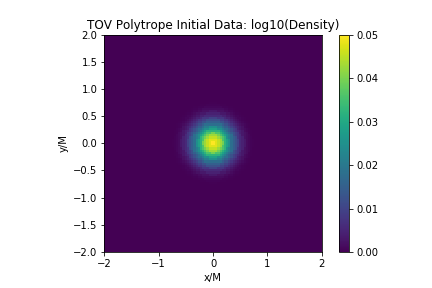

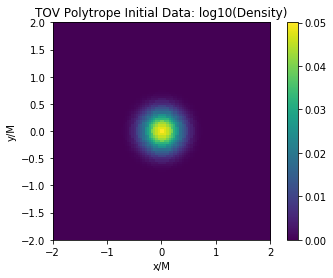

In [25]:
import numpy as np
from scipy.interpolate import griddata
from pylab import savefig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image

x96,y96,valuesCF96,valuesHam96 = np.loadtxt('out96.txt').T #Transposed for easier unpacking

bounds = 2.0
pl_xmin = -bounds
pl_xmax = +bounds
pl_ymin = -bounds
pl_ymax = +bounds

grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:100j, pl_ymin:pl_ymax:100j]
points96 = np.zeros((len(x96), 2))
for i in range(len(x96)):
    points96[i][0] = x96[i]
    points96[i][1] = y96[i]

grid96 = griddata(points96, valuesCF96, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points96, valuesCF96, (grid_x, grid_y), method='cubic')

plt.clf()
plt.title("TOV Polytrope Initial Data: log10(Density)")
plt.xlabel("x/M")
plt.ylabel("y/M")

# fig, ax = plt.subplots()
# ax.plot(grid96cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
# plt.close(fig)
fig96cf = plt.imshow(grid96.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
cb = plt.colorbar(fig96cf)
savefig("BHB.png")
from IPython.display import Image
Image("BHB.png")
# #           interpolation='nearest', cmap=cm.gist_rainbow)

## Validation: Convergence of numerical errors (Hamiltonian constraint violation) to zero

The equations behind these initial data solve Einstein's equations exactly, at a single instant in time. One reflection of this solution is that the Hamiltonian constraint violation should be exactly zero in the initial data. 

However, when evaluated on numerical grids, the Hamiltonian constraint violation will *not* generally evaluate to zero due to the associated numerical derivatives not being exact. However, these numerical derivatives (finite difference derivatives in this case) should *converge* to the exact derivatives as the density of numerical sampling points approaches infinity.

In this case, all of our finite difference derivatives agree with the exact solution, with an error term that drops with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$. 

Here, as in the [Start-to-Finish Scalar Wave (Cartesian grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWave.ipynb) and the [Start-to-Finish Scalar Wave (curvilinear grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWaveCurvilinear.ipynb) we confirm this convergence.

First, let's take a look at what the numerical error looks like on the x-y plane at a given numerical resolution, plotting $\log_{10}|H|$, where $H$ is the Hamiltonian constraint violation:

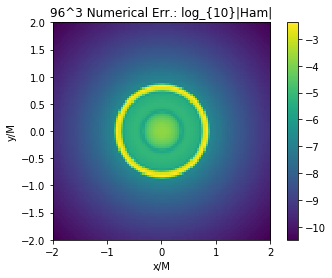

In [26]:
grid96 = griddata(points96, valuesHam96, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points96, valuesHam96, (grid_x, grid_y), method='cubic')

# fig, ax = plt.subplots()

plt.clf()
plt.title("96^3 Numerical Err.: log_{10}|Ham|")
plt.xlabel("x/M")
plt.ylabel("y/M")

fig96cub = plt.imshow(grid96cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
cb = plt.colorbar(fig96cub)

Next, we set up the same initial data but on a lower-resolution, $48^3$ grid. Since the constraint violation (numerical error associated with the fourth-order-accurate, finite-difference derivatives) should converge to zero with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$, we expect the constraint violation will increase (relative to the $96^3$ grid) by a factor of $\left(96/48\right)^4$. Here we demonstrate that indeed this order of convergence is observed as expected. I.e., at all points *except* at the points immediately surrounding the coordinate center of the black hole (due to the spatial slice excising the physical singularity at this point through [the puncture method](http://gr.physics.ncsu.edu/UMD_June09.pdf)) exhibit numerical errors that drop as $\left(\Delta x^i\right)^4$.

<Figure size 432x288 with 0 Axes>

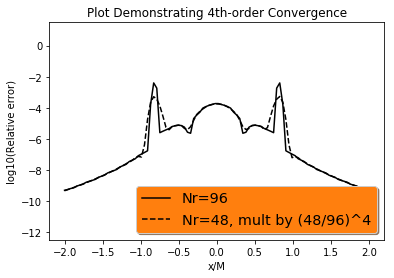

In [27]:
!taskset -c 0 ./TOV_Playground 48 48 48 > out48.txt

x48,y48,valuesCF48,valuesHam48 = np.loadtxt('out48.txt').T #Transposed for easier unpacking
points48 = np.zeros((len(x48), 2))
for i in range(len(x48)):
    points48[i][0] = x48[i]
    points48[i][1] = y48[i]

grid48 = griddata(points48, valuesHam48, (grid_x, grid_y), method='cubic')

griddiff_48_minus_96 = np.zeros((100,100))
griddiff_48_minus_96_1darray = np.zeros(100*100)
gridx_1darray_yeq0 = np.zeros(100)
grid48_1darray_yeq0 = np.zeros(100)
grid96_1darray_yeq0 = np.zeros(100)
count = 0
outarray = []
for i in range(100):
    for j in range(100):
        griddiff_48_minus_96[i][j] = grid48[i][j] - grid96[i][j]
        griddiff_48_minus_96_1darray[count] = griddiff_48_minus_96[i][j]
        if j==49:
            gridx_1darray_yeq0[i] = grid_x[i][j]
            grid48_1darray_yeq0[i] = grid48[i][j] + np.log10((48./96.)**4)
            grid96_1darray_yeq0[i] = grid96[i][j]
        count = count + 1

plt.clf()
fig, ax = plt.subplots()
plt.title("Plot Demonstrating 4th-order Convergence")
plt.xlabel("x/M")
plt.ylabel("log10(Relative error)")

ax.plot(gridx_1darray_yeq0, grid96_1darray_yeq0, 'k-', label='Nr=96')
ax.plot(gridx_1darray_yeq0, grid48_1darray_yeq0, 'k--', label='Nr=48, mult by (48/96)^4')
ax.set_ylim([-12.5,1.5])

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()

In [28]:
!jupyter nbconvert --to latex --template latex_nrpy_style.tplx Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.tex
!rm -f Tut*.out Tut*.aux Tut*.log

[NbConvertApp] Converting notebook Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb to latex
[NbConvertApp] Support files will be in Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data_files/
[NbConvertApp] Making directory Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data_files
[NbConvertApp] Making directory Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data_files
[NbConvertApp] Making directory Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data_files
[NbConvertApp] Writing 137554 bytes to Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.1415